# Layer-wise Relevance Propagation (LRP)
##### - Jung Jung Ho 

In [82]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf

print("Tensorflow version: ", tf.__version__)

Tensorflow version:  2.1.0


In [83]:
(train_X, train_y) , (test_X, test_y) = tf.keras.datasets.mnist.load_data()

In [84]:
train_X.shape

(60000, 28, 28)

In [48]:
from tensorflow.keras.layers import *

strides = (1,1)

#input_shape = (28, 28, 1)
n = len(train_X)
train_X = train_X.reshape((-1,28,28,1))

CNN = tf.keras.Sequential()

CNN.add(Conv2D(input_shape = (28,28,1),
               filters = 5, kernel_size = (5,5),
               strides = strides, padding="same", 
               activation = 'relu'))

CNN.add(MaxPool2D(pool_size = (2,2)))

CNN.add(Conv2D(filters = 5, kernel_size = (5,5),
               strides = strides, padding = "same",
               activation = 'relu'))

CNN.add(MaxPool2D(pool_size = (2,2)))

CNN.add(Conv2D(filters = 20, kernel_size = (5,5),
               strides = strides, padding = "same",
               activation = 'relu'))

#CNN.add(Dropout(1.0))

CNN.add(Flatten())

CNN.add(Dense(units = 10, activation = "softmax"))



In [49]:
CNN.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 28, 28, 5)         130       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 14, 14, 5)         0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 14, 14, 5)         630       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 7, 7, 5)           0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 7, 7, 20)          2520      
_________________________________________________________________
flatten_1 (Flatten)          (None, 980)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)               

In [50]:
CNN.compile(loss = "sparse_categorical_crossentropy", optimizer = "rmsprop", metrics = ["accuracy"])

In [51]:
CNN.fit(train_X, train_y, epochs = 7, batch_size=6000, validation_split=0.25
            , callbacks = [tf.keras.callbacks.EarlyStopping(patience=5, monitor="val_loss")])

Train on 45000 samples, validate on 15000 samples
Epoch 1/7
45000/45000 [==============================] - 9s 197us/sample - loss: 13.9307 - accuracy: 0.2408 - val_loss: 2.7751 - val_accuracy: 0.5146
Epoch 2/7
45000/45000 [==============================] - 8s 186us/sample - loss: 2.1866 - accuracy: 0.5821 - val_loss: 1.3697 - val_accuracy: 0.6956
Epoch 3/7
45000/45000 [==============================] - 9s 202us/sample - loss: 1.2263 - accuracy: 0.7159 - val_loss: 0.9971 - val_accuracy: 0.7629
Epoch 4/7
45000/45000 [==============================] - 10s 226us/sample - loss: 0.9067 - accuracy: 0.7786 - val_loss: 0.8398 - val_accuracy: 0.7953
Epoch 5/7
45000/45000 [==============================] - 10s 232us/sample - loss: 0.7442 - accuracy: 0.8113 - val_loss: 0.6162 - val_accuracy: 0.8434
Epoch 6/7
45000/45000 [==============================] - 10s 227us/sample - loss: 0.6168 - accuracy: 0.8390 - val_loss: 0.6568 - val_accuracy: 0.8341
Epoch 7/7
45000/45000 [=============================

In [52]:
CNN.layers

In [53]:

hidden_1, pool_1, hidden_2, pool_2, hidden_3 = CNN.layers[0], \
                                               CNN.layers[1], \
                                               CNN.layers[2], \
                                               CNN.layers[3], \
                                               CNN.layers[4]

layers = [hidden_1, pool_1, hidden_2, pool_2, hidden_3]

#layers = CNN.layers[:-2]

weights = CNN.get_weights()[::2]
biases = CNN.get_weights()[1::2]



In [54]:
hidden_1(tf.cast(test_X[:3,:].reshape(-1,28,28,1), tf.float32))

<tf.Tensor: shape=(3, 28, 28, 5), dtype=float32, numpy=
array([[[[0.        , 0.        , 0.01378341, 0.        , 0.        ],
         [0.        , 0.        , 0.01378341, 0.        , 0.        ],
         [0.        , 0.        , 0.01378341, 0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.01378341, 0.        , 0.        ],
         [0.        , 0.        , 0.01378341, 0.        , 0.        ],
         [0.        , 0.        , 0.01378341, 0.        , 0.        ]],

        [[0.        , 0.        , 0.01378341, 0.        , 0.        ],
         [0.        , 0.        , 0.01378341, 0.        , 0.        ],
         [0.        , 0.        , 0.01378341, 0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.01378341, 0.        , 0.        ],
         [0.        , 0.        , 0.01378341, 0.        , 0.        ],
         [0.        , 0.        , 0.01378341, 0.        , 0.        ]],

        [[0.        , 0.        , 0.01378341, 0.        , 0.

In [55]:
from tensorflow.python.ops import gen_nn_ops

class visLayer():
    def __init__(self, data, N, layers):
        self.data = data
        self.N = N
        self.layers = layers
        self.n_layers = len(layers)
        
        self.by_data = dict()
        
        for i in range(N):
            tmp = self.data[i]
            tmp = tf.cast(tmp.reshape(-1,*tmp.shape), tf.float32)
            data_activation = [tmp]
            for layer in self.layers:
                tmp = layer(tmp)
                data_activation.append(tmp)
            self.by_data["data_{}".format(i)] = data_activation

    
    def show(self):
        for data_depict in self.by_data.values():
            plt.figure(figsize = ((self.n_layers+1)*5,5))
            for i, image in enumerate(data_depict):
                plt.subplot(1, self.n_layers+1, i+1)
                collapse = tf.math.reduce_mean(image, axis = 3)
                plt.imshow(tf.reshape(collapse, collapse.shape[1:]), interpolation = "nearest", cmap = "gray")
            plt.show()
            
        

In [56]:
ttt = visLayer(train_X, layers = layers, N = 10)

In [57]:
layers

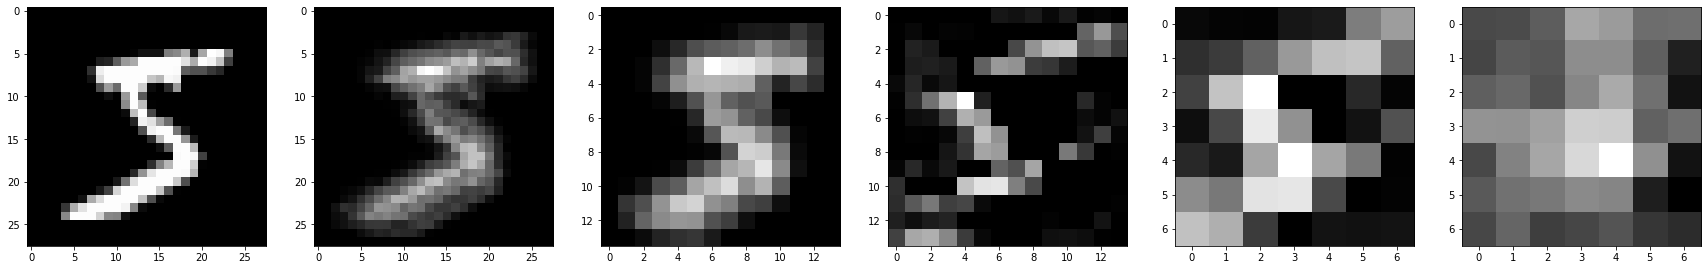

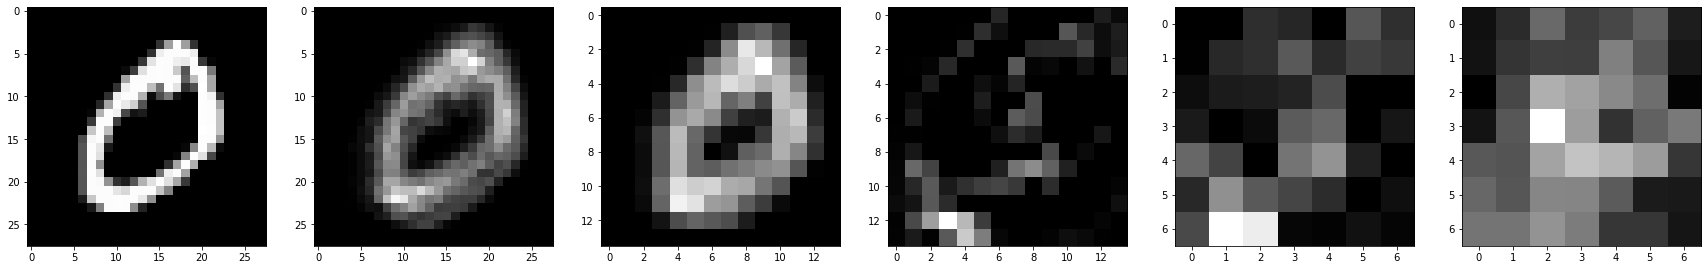

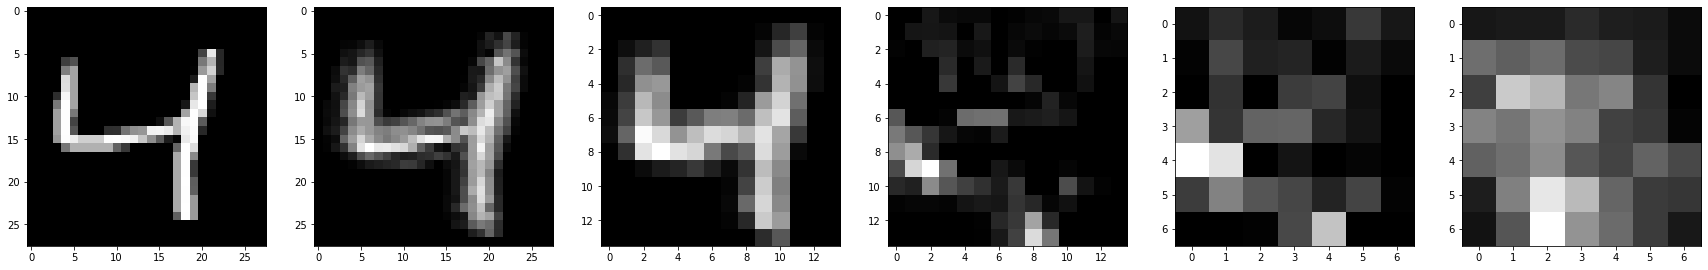

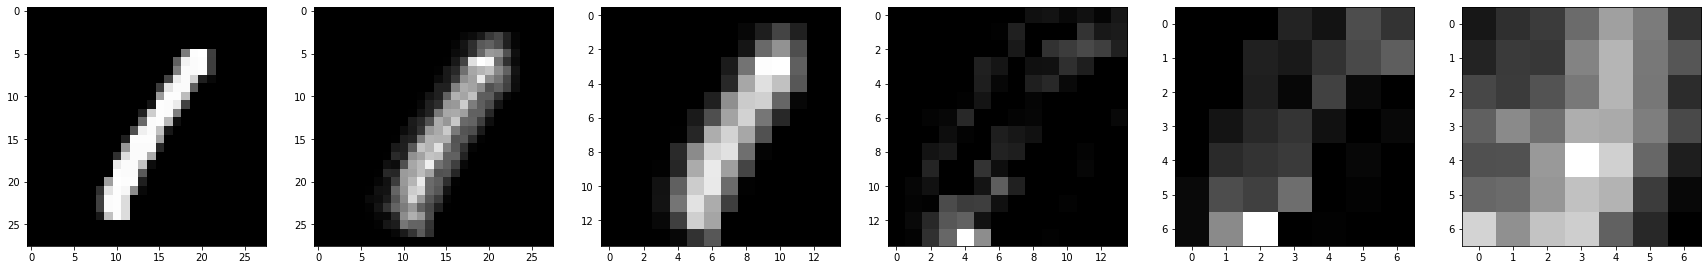

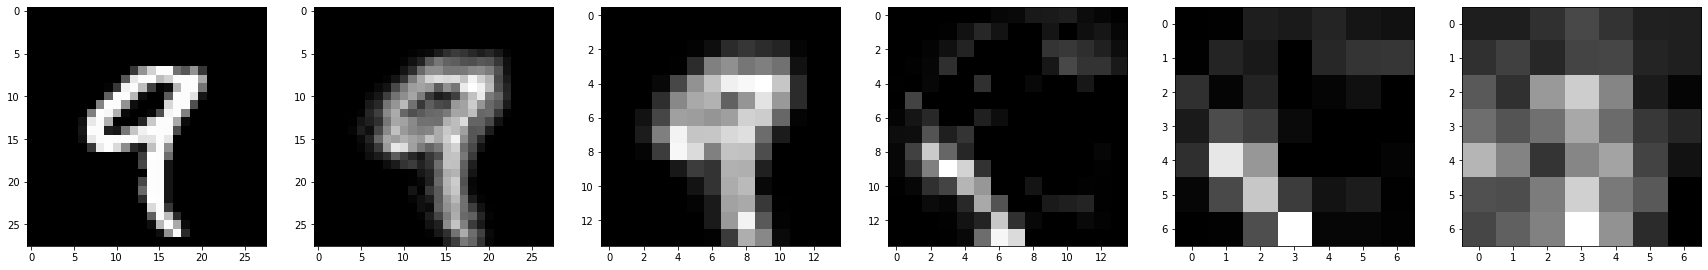

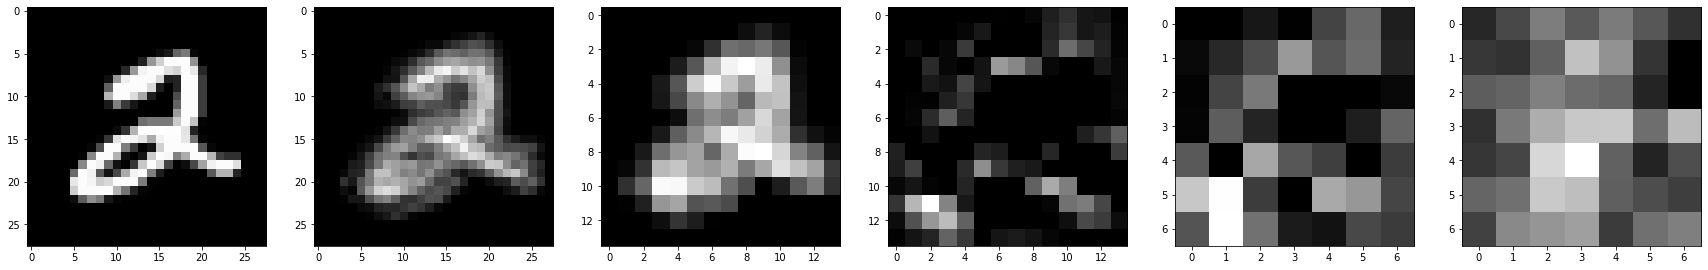

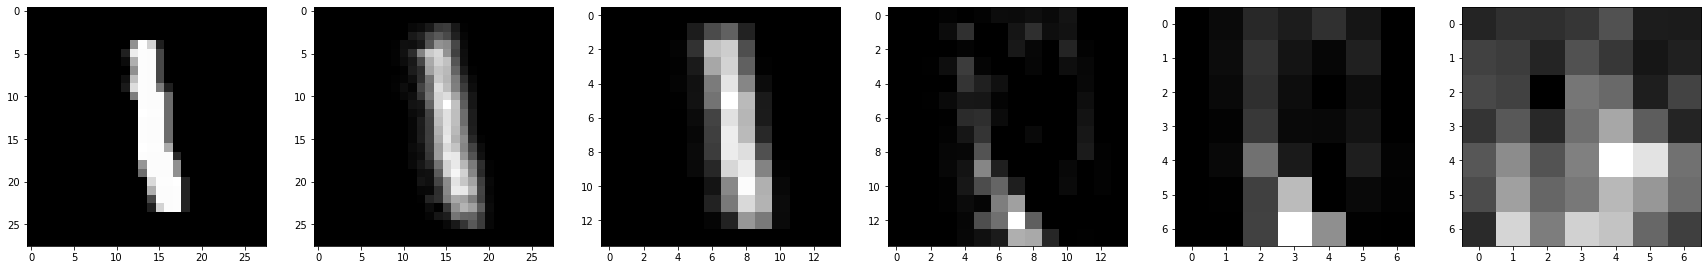

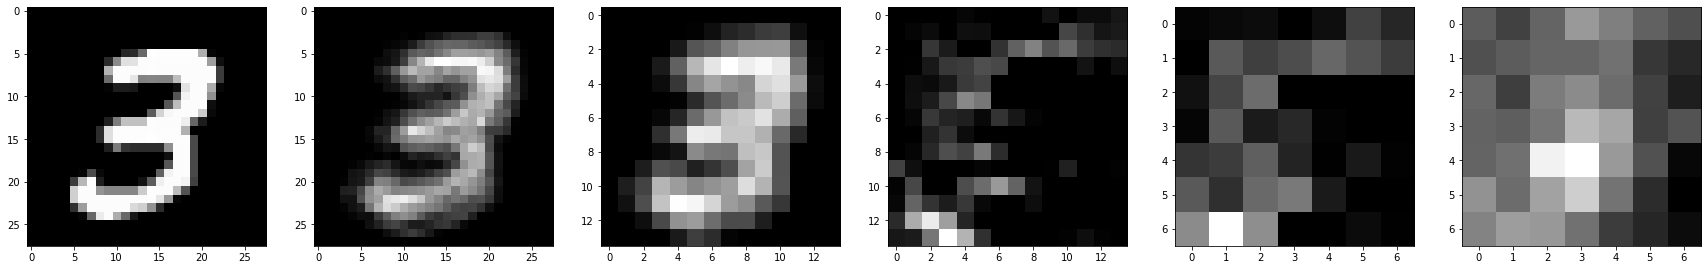

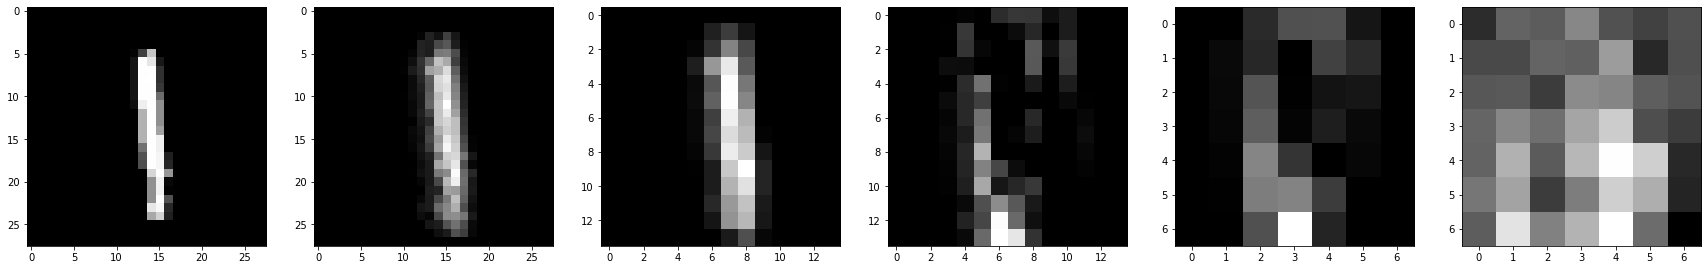

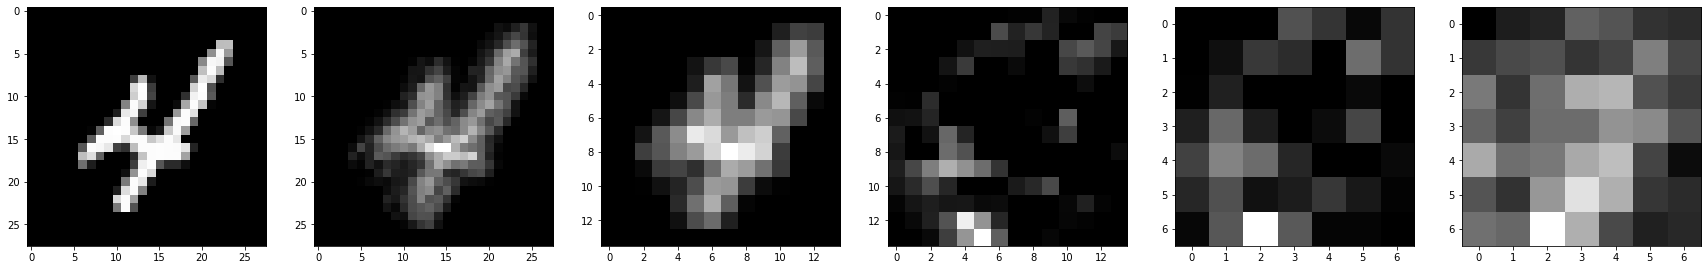

In [58]:
ttt.show()

In [59]:
import copy
tmp = train_X[0,:].reshape(-1,28,28,1)
tmp = tf.cast(tmp, tf.float32)
activations = []

a = copy.deepcopy(tmp)

for layer in layers:
    a = layer(a)
    activations.append(a)

In [60]:
layers, [*map(lambda x: x.shape, weights)], [*map(lambda x: x.shape, biases)], [*map(lambda x: x.shape, activations)]

([<tensorflow.python.keras.layers.convolutional.Conv2D at 0x7f22d4723fd0>,
 [(5, 5, 1, 5), (5, 5, 5, 5), (5, 5, 5, 20), (980, 10)],
 [(5,), (5,), (20,), (10,)],
 [TensorShape([1, 28, 28, 5]),
  TensorShape([1, 14, 14, 5]),
  TensorShape([1, 14, 14, 5]),
  TensorShape([1, 7, 7, 5]),
  TensorShape([1, 7, 7, 20])])

In [61]:
def getGradient(activation, weight, bias):
    W = tf.math.maximum(0., weight)
    b = tf.math.maximum(0., bias)
    z = tf.matmul(activation, W) + b
    
    dX = tf.matmul(1/z, tf.transpose(W))
    
    return dX

In [62]:
def backprop_dense(activation, weight, bias, relevance):
    W = tf.math.maximum(0., weight)
    b = tf.math.maximum(0., bias)
    z = tf.matmul(activation, W) + b
    
    s = relevance / z
    c = tf.matmul(s, tf.transpose(W))
    
    return activation * c

In [63]:
from tensorflow.python.ops import gen_nn_ops

def backprop_pooling(activation, relevance):

    z = MaxPool2D(pool_size = (2,2))(activation) + 1e-10
    s = relevance / z

    c = gen_nn_ops.max_pool_grad_v2(orig_input = activation, orig_output = z, grad = s, 
                                   ksize = [1,2,2,1], strides = [1,2,2,1], padding = "SAME")
    
    return activation*c

In [64]:
def backprop_conv(activation, weight, bias, relevance):
    strides = (1,1)
    W = tf.math.maximum(0., weight)
    b = tf.math.maximum(0., bias)
    layer = Conv2D(filters = W.shape[-1], kernel_size = (W.shape[0], W.shape[1]), padding= "SAME")
    
    layer.build(input_shape = activation.shape)

    layer.set_weights([W,b])
    z = layer(activation)
    # z = tf.nn.conv2d(activation, w, strides, padding = "SAME")
    # z = tf.nn.bias_add(z,b)
    s = relevance / z
    c = tf.compat.v1.nn.conv2d_backprop_input(activation.shape, w, s, [1,*strides,1], padding = 'SAME')
    return activation * c

In [65]:
R4 = CNN.predict(tmp)

In [66]:
R4, R4.sum()

(array([[5.5913559e-12, 9.4177117e-11, 6.6056010e-09, 4.3516538e-01,
         8.8017068e-12, 5.6481642e-01, 2.2824447e-11, 1.8128334e-05,
         2.8297348e-10, 7.6332711e-08]], dtype=float32),
 0.99999994)

In [67]:
a = activations[-1]
w = weights[-1]
b = biases[-1]

print(a.shape)
print(w.shape)

R3 = backprop_dense(tf.reshape(a, (1,980)), w, b, R4)

print(R3.shape)

R3

(1, 7, 7, 20)
(980, 10)
(1, 980)


<tf.Tensor: shape=(1, 980), dtype=float32, numpy=
array([[1.07525912e-10, 0.00000000e+00, 3.51149286e-03, 7.69372843e-03,
        8.39273038e-04, 0.00000000e+00, 0.00000000e+00, 5.29915374e-03,
        7.84183101e-08, 1.20134978e-03, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 6.48230896e-04, 0.00000000e+00, 5.88681549e-04,
        1.49673864e-03, 0.00000000e+00, 0.00000000e+00, 2.89482214e-05,
        2.14655767e-03, 1.81333883e-06, 0.00000000e+00, 3.46727989e-04,
        0.00000000e+00, 0.00000000e+00, 1.46796741e-03, 1.20483618e-03,
        1.07118313e-03, 0.00000000e+00, 2.08849693e-09, 0.00000000e+00,
        1.72333175e-03, 0.00000000e+00, 9.85857216e-04, 0.00000000e+00,
        3.37476406e-04, 0.00000000e+00, 0.00000000e+00, 9.38728206e-09,
        5.64378500e-03, 3.97945958e-04, 7.47023558e-04, 1.85225392e-03,
        2.45457079e-04, 0.00000000e+00, 4.81044175e-03, 8.85827118e-04,
        0.00000000e+00, 6.55645563e-05, 6.50270740e-05, 0.00000000e+00,
        0.0000

In [68]:
w = weights[-2]
b = biases[-2]
p = activations[-2]
a = activations[-3]

print(w.shape)
print(b.shape)
print(p.shape)
print(a.shape)

R_conv = backprop_conv(p,w,b,tf.reshape(R3, (1,7,7,20)))
print(R_conv.shape)

R2 = backprop_pooling(a, R_conv)
print(R2.shape)

#plt.imshow(tf.math.reduce_mean(tf.reshape(R2, [*R2.shape[1:]] ), axis = 2), interpolation = "nearest", cmap = "RdBu")

(5, 5, 5, 20)
(20,)
(1, 7, 7, 5)
(1, 14, 14, 5)
(1, 7, 7, 5)
(1, 14, 14, 5)


In [69]:
w = weights[-3]
b = biases[-3]
p = activations[-4]
a = activations[-5]


print(w.shape)
print(b.shape)
print(p.shape)
print(a.shape)

R_conv = backprop_conv(p, w, b, R2)
print(R_conv.shape)

R1 = backprop_pooling(a, R_conv)
print(R1.shape)
print(np.sum(R1))

(5, 5, 5, 5)
(5,)
(1, 14, 14, 5)
(1, 28, 28, 5)
(1, 14, 14, 5)
(1, 28, 28, 5)
0.17600967


In [70]:
w = weights[0]
b = biases[0]
#img_activations = getActivations
R0 = backprop_conv(tmp,w,b,R1)

In [75]:
final_tmp = copy.deepcopy(R0)
final_tmp[(final_tmp!=final_tmp)] 

<tf.Tensor: shape=(650,), dtype=float32, numpy=
array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan,

In [40]:
final_tmp[(final_tmp!=final_tmp)]

4

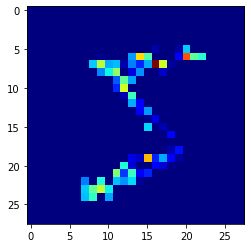

In [81]:
plt.imshow(np.maximum(0., np.nan_to_num(final_tmp)).reshape(28,28),cmap = plt.cm.jet)